In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys
import gym
import shap
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

sys.path.append("..")

from models.DQN import DQNAgent
from models.PPO import PPOAgent
from models.DDPG import DDPGAgent
from mpl_toolkits import mplot3d
from core.visuals import *
from models.reward_functions import *
from tensorflow.keras.layers import *
from core.stochastic_similarity import similarity
from tensorflow.keras.optimizers import *


plt.style.use("ggplot")

In [ ]:
env = gym.make("LunarLander-v2")
dqn_agent = DQNAgent(env, Identity, RMSprop(1e-4, decay=0.99), model_name='lunarlander', batch_size=32, warmup=0, validation_logging=5,validation_episodes=5,layers=[128,128],activation='relu',epsilon_min=0.05,epsilon_decay=0.999,tau=0.01,reg=0.01,gamma=0.999)
dqn_agent.learn(1000)

In [ ]:
frames, observations, actions = run_model(env, 100, dqn_agent.critic.predict)

In [84]:
env = gym.make("LunarLander-v2")
dqn_shap_agent = DQNAgent(env, dqn_shap, RMSprop(1e-4, decay=0.99), model_name='lunarlander', batch_size=32, warmup=0, validation_logging=5,validation_episodes=5,layers=[128,128],activation='relu',epsilon_min=0.05,epsilon_decay=0.999,tau=0.01,reg=0.01,gamma=0.999)
dqn_agent.learn(1000)

In [78]:
for i in range(8):
    for j in range(8):
        plot = action_space_contour(env, i, j, dqn_agent.critic.batch_predict, discrete=True, figsize=(8, 6), dpi=150)
        plt.title("Shapley Reward Policy")
        plt.savefig(f"dqn_shap_plots/obs{i}{j}.png")
        plt.close();

In [92]:
dqn_agent = DQNAgent(env, Identity, RMSprop(1e-4, decay=0.9), model_name='lunarlander_testing', batch_size=256, warmup=0, validation_logging=5, validation_episodes=5, layers=[128,128], activation=ELU, epsilon_min=0.01, epsilon_decay=0.999, tau=0.01, reg=0.01, gamma=0.999)
dqn_agent.load("../saved_models/lunarlander_testing/DQN6/best_model")


WARN: Box bound precision lowered by casting to float32


Episode Reward = -11.449148377510198
Episode Reward = -5.135901884993544
Episode Reward = -203.33471389014042
Episode Reward = -39.47298591649869
Episode Reward = -205.49949434075305
Episode Reward = -22.18707121814373
Episode Reward = -86.89405239848752
Episode Reward = -175.74806166763483
Episode Reward = -123.07571342609245
Episode Reward = -239.47778496463386


In [184]:
env_cont = gym.make("LunarLanderContinuous-v2")

ddpg_agent = DDPGAgent(env_cont, Identity, critic_optimizer=RMSprop(5e-3, decay=0.75),actor_optimizer=RMSprop(5e-3, decay=0.99),model_name='reloading',batch_size=256,warmup=0,actor_layers=[128,256],critic_layers=[128,256],actor_reg=0.01,critic_reg=0.01,activation=ELU,
    epsilon_min=0.01,tau=0.01,gamma=0.999,validation_logging=10,validation_episodes=5)
ddpg_agent.load("../saved_models/lunarlander_testing/DDPG14/best_model")

WARN: Box bound precision lowered by casting to float32


In [185]:
_ = run_model(env_cont, 10, ddpg_agent.actor.predict)

Episode Reward = -255.47762262902583
Episode Reward = -134.59349783519673
Episode Reward = -21.384668702073554
Episode Reward = -120.72481669824893
Episode Reward = -133.37632461554603
Episode Reward = -411.00634944575177
Episode Reward = -139.098258746876
Episode Reward = -356.9938868761078
Episode Reward = -363.53582450383016
Episode Reward = -136.8012640152647


In [186]:
def test(env, model, i = 0, j = 1, figsize=(12,8)):
    high1 = min(env.observation_space.high[i], 1e8)
    high2 = min(env.observation_space.high[j], 1e8)
    low1 = max(env.observation_space.low[i], -1e8)
    low2 = max(env.observation_space.low[j], -1e8)


    x = np.linspace(low1, high1)
    y = np.linspace(low2, high2)
    mat = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)

    z = np.zeros((50**2, *env.observation_space.shape))
    z[:, i] = mat[:, 0]
    z[:, j] = mat[:, 1]
    out = model(z)

    
    plt.figure(figsize=figsize, dpi=150)
    plt.title("DDPG Agent with Greedy Reward")
    plt.xlabel(f"Observation {i}")
    plt.ylabel(f"Observation {j}")
    
    pred = out[:, 0].reshape(50,50)
    plt.contourf(x,y,pred,cmap='jet')
    plt.colorbar()
    plt.grid(True)
    return fig

In [187]:
for i in range(8):
    for j in range(8):
        fig = test(env_cont, ddpg_agent.actor.batch_predict, i, j, figsize=(8,6))
        plt.savefig(f"ddpg/action1/policy{i}{j}")
        plt.close()

## Shapley Values and Rewards

In [100]:
observations = []
episode_reward = []
for e in range(100):
    total_episode_reward = 0
    obs = env_cont.reset()
    observations.append(obs)
    done = False
    while not done:
        a = ddpg_agent.actor.predict(obs)
        obs, reward_t, done, _ = env_cont.step(a)
        total_episode_reward += reward_t
        observations.append(obs)
    print(f"Episode {e} Reward: {total_episode_reward}")
    episode_reward.append(total_episode_reward)

Episode 0 Reward: -275.085107161775
Episode 1 Reward: 33.5212061473386
Episode 2 Reward: -172.55989315255465
Episode 3 Reward: -139.43015540483606
Episode 4 Reward: -138.5114552593948
Episode 5 Reward: -206.48812030854148
Episode 6 Reward: -171.53215644702027
Episode 7 Reward: 30.028335840151726
Episode 8 Reward: -280.46927529654863
Episode 9 Reward: -23.539782368888737
Episode 10 Reward: -274.58927664547207
Episode 11 Reward: -257.7207240973221
Episode 12 Reward: -95.05799486824978
Episode 13 Reward: -177.08614989775722
Episode 14 Reward: -355.07374198584546
Episode 15 Reward: -89.03008318047617
Episode 16 Reward: -135.83867128977053
Episode 17 Reward: -220.45873507303196
Episode 18 Reward: -133.10103819012423
Episode 19 Reward: -230.7306732101936
Episode 20 Reward: -108.49933225908413
Episode 21 Reward: -137.68662556523196
Episode 22 Reward: -25.435932860914377
Episode 23 Reward: -180.5611970340634
Episode 24 Reward: -247.18844741351535
Episode 25 Reward: -155.53087063198143
Episode 

In [111]:
observations = np.array(observations)
ind = np.random.choice(np.arange(len(observations)), size=512, replace=False)
x_train = observations[ind]
explainer = shap.KernelExplainer(ddpg_agent.actor.batch_predict, x_train)

In [ ]:
shap_vals = []
reward = []

done = False
obs = env_cont.reset()
while not done:
    a = ddpg_agent.actor.predict(obs)
    shap_vals.append(explainer.shap_values(np.expand_dims(obs, axis=0))[0])
    obs, rt, done, _ = env_cont.step(a)
    reward.append(rt)
plt.plot(reward, '-.')

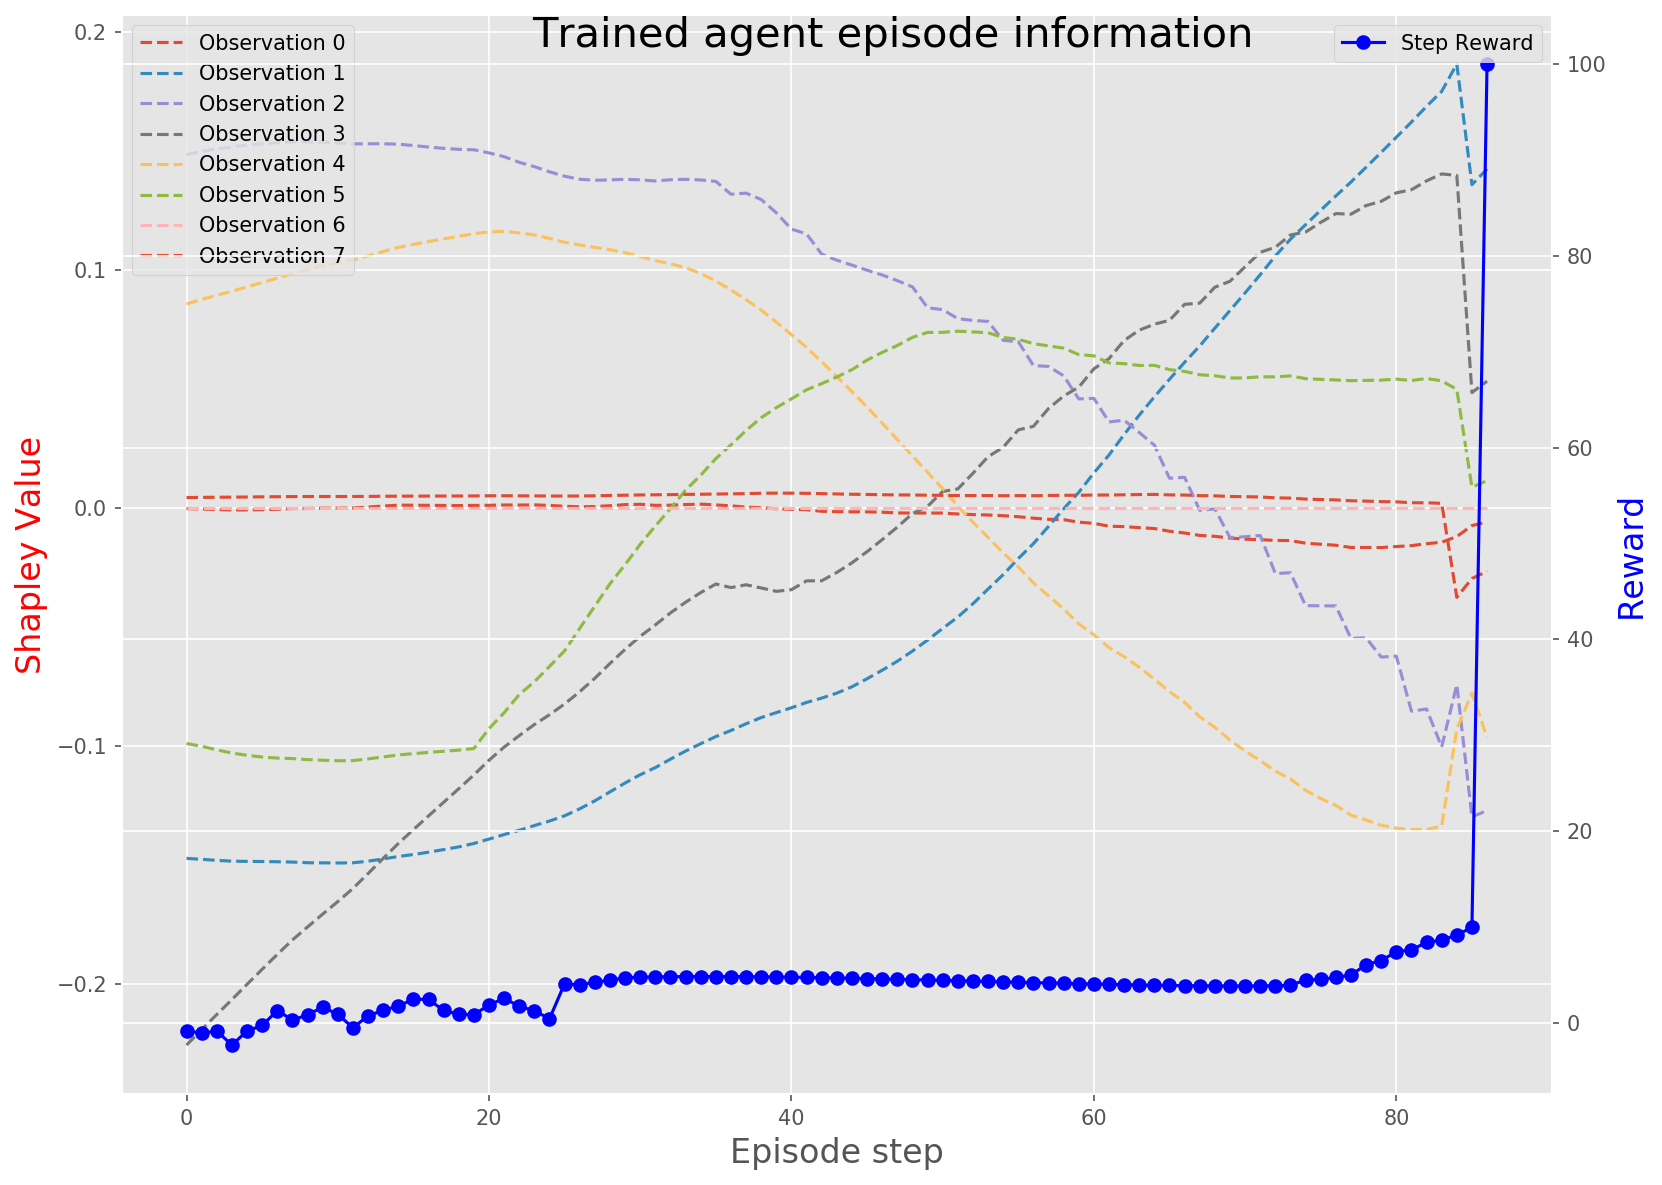

In [189]:
shap_vals = np.array(shap_vals).squeeze()
fig, ax = plt.subplots(figsize=(12,8), dpi=150)
fig.suptitle("Trained agent episode information", fontsize=20)
ax.set_xlabel("Episode step", fontsize=16)
ax.set_ylabel("Shapley Value", fontsize=16, color='red')
for i in range(shap_vals.shape[1]):
    ax.plot(shap_vals[:, i], '--', label=f"Observation {i}")
ax.legend(loc="upper left")    

ax2 = ax.twinx()
ax2.plot(reward, 'o-', c='blue', label=f"Step Reward")
ax2.set_ylabel("Reward", fontsize=16, color='blue')
ax2.legend(bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("episode_info")